# Para ler grib com Xarray precisa instalar CFGRIB: https://pypi.org/project/cfgrib/

# **Importa bibliotecas**

In [1]:
import xarray as xr
import time
import pandas as pd
import proplot as pplt
import glob

import warnings
warnings.filterwarnings('ignore')

# **Leitura do dado**

In [2]:
# definição do período de dados
anoi = 2021 # ano inicial
anof = 2021 # ano final

files = []
for ano in range(anoi, anof+1):
    files = files + glob.glob(f'dados_merge/{ano}/*_{ano}*grib2')
files

['dados_merge/2021\\MERGE_CPTEC_20210101.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210102.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210103.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210104.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210105.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210106.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210107.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210108.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210109.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210110.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210111.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210112.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210113.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210114.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210115.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210116.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210117.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210118.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210119.grib2',
 'dados_merge/2021\\MERGE_CPTEC_20210120.grib2',
 'dados_merge/2021\\

In [3]:
%%time

# leitura dos dados
"""
ds = xr.open_mfdataset('dados_merge/2022/*grib2', 
                       engine="cfgrib", 
                       concat_dim = 'step', 
                       combine='nested')
"""
ds = xr.open_mfdataset(files, 
                       engine="cfgrib", 
                       concat_dim = 'step', 
                       combine='nested')

# transforma longitudes
ds.coords['longitude'] = ((ds.coords['longitude'] + 180) % 360) - 180 
ds = ds.sortby(ds.longitude)

# mostra os dados
ds

Ignoring index file 'dados_merge/2021\\MERGE_CPTEC_20210101.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file 'dados_merge/2021\\MERGE_CPTEC_20210102.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file 'dados_merge/2021\\MERGE_CPTEC_20210103.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file 'dados_merge/2021\\MERGE_CPTEC_20210104.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file 'dados_merge/2021\\MERGE_CPTEC_20210105.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file 'dados_merge/2021\\MERGE_CPTEC_20210106.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file 'dados_merge/2021\\MERGE_CPTEC_20210107.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file 'dados_merge/2021\\MERGE_CPTEC_20210108.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file 'dados_merge/2021\\MERGE_CPTEC_20210109.grib2.923a8.idx' incompatible with GRIB file
Ignoring index file 'dados_merge/2021\\MERGE_CPTEC_2021

CPU times: total: 7min 46s
Wall time: 13min


<xarray.Dataset>
Dimensions:     (step: 365, latitude: 924, longitude: 1001)
Coordinates:
    time        (step) datetime64[ns] 2021-01-01T12:00:00 ... 2021-12-31T12:0...
  * step        (step) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00 00:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 -60.05 -59.95 -59.85 ... 32.05 32.15 32.25
  * longitude   (longitude) float64 -120.1 -120.0 -119.9 ... -20.15 -20.05
    valid_time  (step) datetime64[ns] 2021-01-01T12:00:00 ... 2021-12-31T12:0...
Data variables:
    prec        (step, latitude, longitude) float32 dask.array<chunksize=(1, 924, 1001), meta=np.ndarray>
    prmsl       (step, latitude, longitude) float32 dask.array<chunksize=(1, 924, 1001), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             consensus
    GRIB_centreDescription:  Consensus
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             Consensus
    history:                 2023-10-19T08:13 GRIB to CDM+CF via cfgrib-0.9.1...

# **Calcula média espacial**

In [7]:
%%time
# definição do quadrado 
lat_central, lon_central, ds_km = -15.9, -41.90, 20 #=20 km
ds_graus = ds_km/100.0

lat_min = lat_central - ds_graus
lat_max = lat_central + ds_graus
lon_min = lon_central - ds_graus
lon_max = lon_central + ds_graus

# recorta os dados para a região do quadrado
ds_mean = ds.sel(longitude=slice(lon_min, lon_max), latitude=slice(lat_min, lat_max))

# calcula a média espacial dentro da região
ds_space = ds_mean.mean(dim=['latitude', 'longitude'])

# transforma para tabela
df = ds_space.to_dataframe()

# transformando a coluna "time" para "datetime"
df['time'] = pd.to_datetime(df['time'])

# seta a coluna "time" para índice da tabela
df.set_index('time', inplace=True)

# elimina colunas desnecessárias
df.drop(columns=['surface','valid_time','prmsl'], inplace=True)

# mostra os dados
df

CPU times: total: 12.3 s
Wall time: 24.7 s


,prec
time,
2021-01-01 12:00:00,0.000000
2021-01-02 12:00:00,0.000000
2021-01-03 12:00:00,0.007812
2021-01-04 12:00:00,3.203125
2021-01-05 12:00:00,0.035156
...,...
2021-12-27 12:00:00,70.382812
2021-12-28 12:00:00,93.875000
2021-12-29 12:00:00,22.222656


In [9]:
# salva para arquivo CSV
df.to_csv('merge.csv', sep=';')

# **Plota figura**

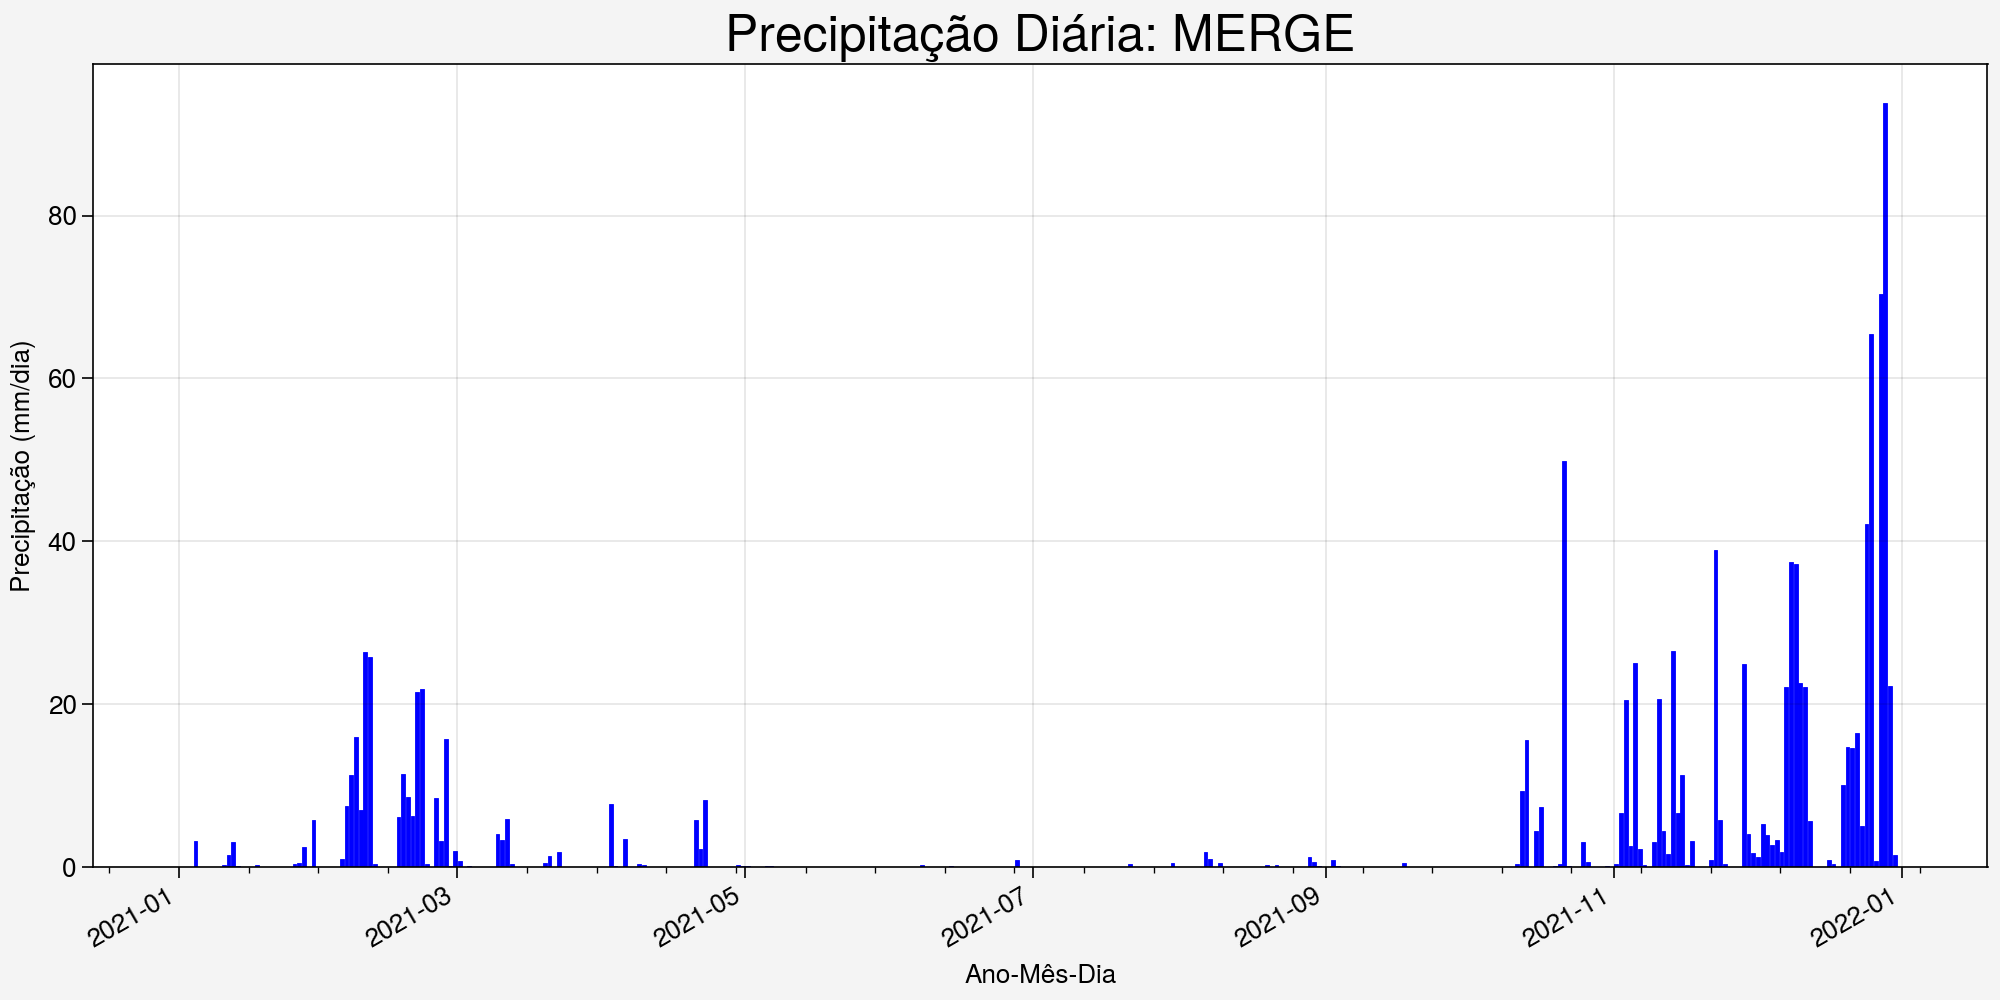

CPU times: total: 2.08 s
Wall time: 3.76 s


In [6]:
%%time
# cria a moldura da figura
fig, ax = pplt.subplots(figsize=(10,5), tight=True)

# plota gráfico de barras
ax.bar(df['prec'].index, 
       df['prec'], 
       color='blue')

# formato dos eixos
ax.format(title='Precipitação Diária: MERGE', 
          xlabel='Ano-Mês-Dia', 
          ylabel='Precipitação (mm/dia)',
          small='13px', 
          large='25px', 
          xrotation=30,
          ytickminor=False)

# salva figura
fig.save(f'merge_total_diaria.jpg', dpi=300)

# exibe figura na tela
pplt.show()